In [21]:
# Computational imports
import numpy as np   # Library for n-dimensional arrays
import pandas as pd  # Library for dataframes (structured data)

# ML imports
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, TimeSeriesSplit

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

# I like to disable my Notebook Warnings.
import warnings
warnings.filterwarnings('ignore')

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
seed(1)

# Allows us to see more information regarding the DataFrame
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

In [9]:
df=pd.read_csv(r'car_data.csv')
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [10]:
df.isnull().sum()

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

In [11]:
df.shape

(301, 9)

In [12]:
print(df['Seller_Type'].unique())
print(df['Fuel_Type'].unique())
print(df['Transmission'].unique())
print(df['Owner'].unique())

['Dealer' 'Individual']
['Petrol' 'Diesel' 'CNG']
['Manual' 'Automatic']
[0 1 3]


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [14]:
df.dtypes

Car_Name          object
Year               int64
Selling_Price    float64
Present_Price    float64
Kms_Driven         int64
Fuel_Type         object
Seller_Type       object
Transmission      object
Owner              int64
dtype: object

In [15]:
df.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


#### Getting all column types :
   Some features are numerical and others are categorical. Depending on the type, different techniques will have to be used     to take care of them. We are going to use a function to generate us the list of columns.

In [16]:
def get_all_cols(df, target_col, exclude=[]):
    
    # Select categorical columns
    object_cols = [cname for cname in df.columns 
                   if df[cname].dtype == "object"]

    # Select numerical columns
    num_cols = [cname for cname in df.columns 
                if df[cname].dtype in ['int64', 'float64', 'uint8']]
    
    all_cols = object_cols + num_cols
    
    exclude_cols = exclude + [target_col]
    
    feature_cols = [col for col in all_cols if col not in exclude_cols]
    
    return object_cols, num_cols, feature_cols

In [17]:
object_cols, num_cols, feature_cols = get_all_cols(df, "Selling_Price")

Note: We exlude Selling_Price because it is the target.

In [18]:
print(object_cols)
print(num_cols)      # Note that num cols does contain the Target column
print(feature_cols)  # Note that feature cols does not contain the Target column

['Car_Name', 'Fuel_Type', 'Seller_Type', 'Transmission']
['Year', 'Selling_Price', 'Present_Price', 'Kms_Driven', 'Owner']
['Car_Name', 'Fuel_Type', 'Seller_Type', 'Transmission', 'Year', 'Present_Price', 'Kms_Driven', 'Owner']


After getting all the categorical columns, let's quickly analyze how many unique values each column takes. This is important to analyze if we want to later on one hot encode a column. A column with 10000 unique values will be very heavy to one hot encode, since it will add 10000-1=9999 new columns.

In [19]:
for object_col in object_cols:
    print(f'{object_col}:{df[object_col].nunique()}\n')

Car_Name:98

Fuel_Type:3

Seller_Type:2

Transmission:2



In our case, it doesn't seem to bad. Worst case, after testing, we can choose to remove the Car_Name one hot encoding.
We can also check the count of each category for a column. We do this using the .value_counts() method.

In [20]:
for object_col in object_cols:
    obj_val_counts = df[object_col].value_counts()
    print(f'{obj_val_counts}\n')

city                         26
corolla altis                16
verna                        14
fortuner                     11
brio                         10
ciaz                          9
innova                        9
i20                           9
grand i10                     8
jazz                          7
amaze                         7
Royal Enfield Classic 350     7
ertiga                        6
eon                           6
sx4                           6
alto k10                      5
i10                           5
swift                         5
Bajaj Pulsar 150              4
Royal Enfield Thunder 350     4
ritz                          4
wagon r                       4
etios liva                    4
dzire                         4
xcent                         3
etios cross                   3
Royal Enfield Thunder 500     3
TVS Apache RTR 160            3
Yamaha FZ S V 2.0             3
creta                         3
Honda CB Hornet 160R          3
etios g 

Plotting
We will explore various plots that could give us valuable insights.

Set the plot styles
Some configurations for the plots to make them look nicer.

In [22]:
colors = sns.color_palette('pastel') # Color palette to use
sns.set(rc={'figure.figsize':(8,6)})
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes
sns.set_style('white') # darkgrid, white grid, dark, white and ticks

#### Bar Plot :
Here we will explore the amount the selling price per fuel type. Goal would be to determine the correlation between the category types to selling price.

<AxesSubplot:xlabel='Fuel_Type', ylabel='Selling_Price'>

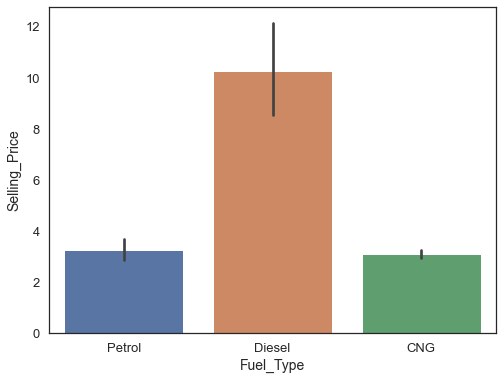

In [24]:
sns.barplot(data=df, x='Fuel_Type', y='Selling_Price')

It is clear from this plot that diesel cars sell for a higher price. This is expected since diesel fuel is more expensive normally.

<AxesSubplot:xlabel='Transmission', ylabel='Selling_Price'>

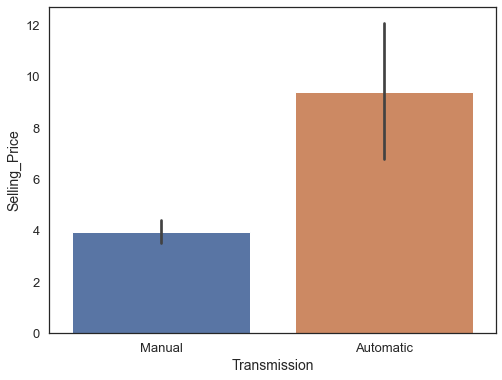

In [25]:
sns.barplot(data=df, x='Transmission', y= 'Selling_Price')

It is clear from this plot that automatic cars sell for a higher price. This is expected since historically automatic car have been sold for a higher price.

<AxesSubplot:xlabel='Seller_Type', ylabel='Selling_Price'>

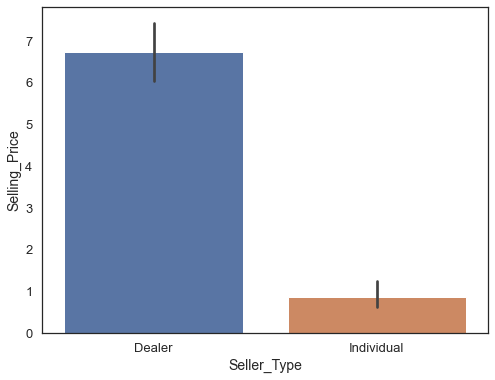

In [26]:
sns.barplot(data=df, x='Seller_Type', y= 'Selling_Price')

<AxesSubplot:xlabel='Year'>

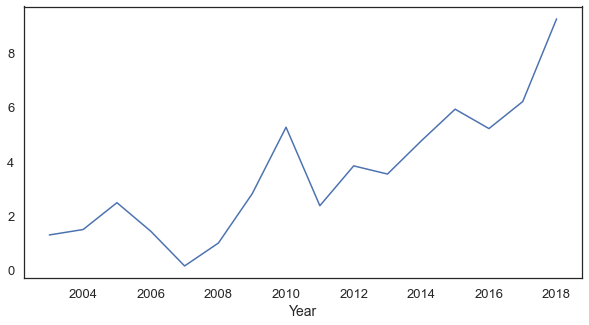

In [29]:
df_grouped_by_year = df.groupby(['Year'])['Selling_Price'].mean()
df_grouped_by_year.plot(figsize = (10,5))

This plot showcases the steady increase of car selling price througout the years. This is expected especially with inflation.

#### Categorical Plot :

Here we will explore the amount of sell, mean and distribution per product. We can look at distribution and see if it close to being a Gaussian distribution and also look at if there are any outliers. Goal would be to analyze the statistical distribution of num_sold depending on each product type.

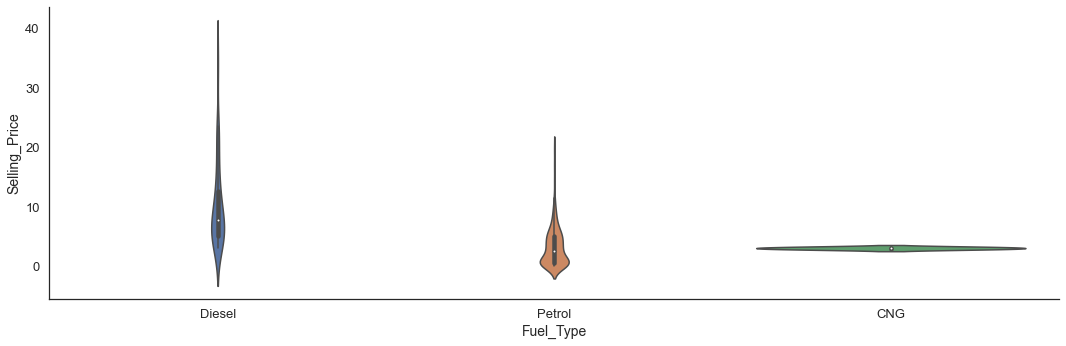

In [30]:
sns.catplot(x='Fuel_Type', y= 'Selling_Price', data = df.sort_values("Selling_Price", ascending = False), kind="violin", height = 5, aspect = 3)
plt.show()

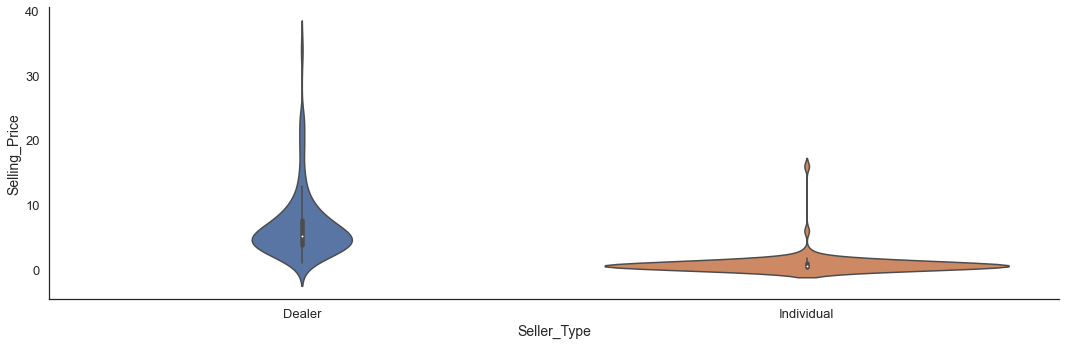

In [31]:
sns.catplot(x='Seller_Type', y= 'Selling_Price', data = df.sort_values("Selling_Price", ascending = False), kind="violin", height = 5, aspect = 3)
plt.show()

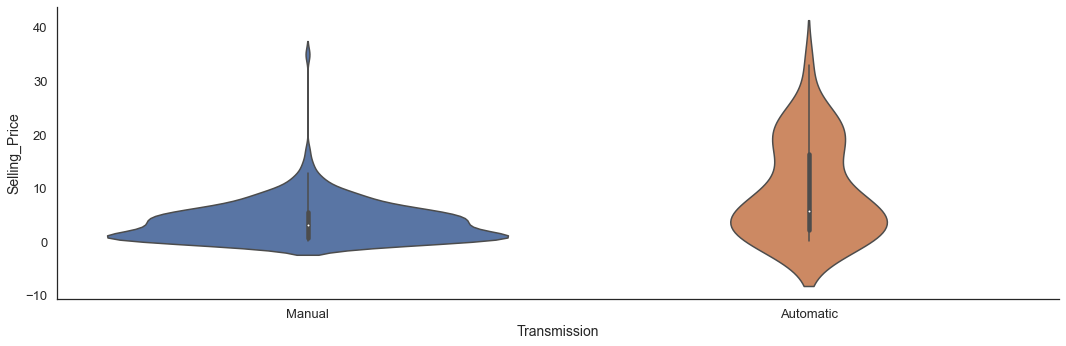

In [32]:
sns.catplot(x='Transmission', y= 'Selling_Price', data = df.sort_values("Selling_Price", ascending = False), kind="violin", height = 5, aspect = 3)
plt.show()

These categorical plots re-inforce what we discovered with the bar plots. They also gives us a quick look at the probability distribution of each category. A lot of them do not follow a gaussian distribution, but that is okay in our case since we will be using XGBoost. Scaling and transforming is espcially important for algorithms that use gradient descent or a distance based learning such as KNN.

What we found: From the EDA, we notice that we do not have any missing data. We also notice we have a year column that we can transform into a year_old column.

##### Feature Engineering :
In this section, we take the data and preprocess and engineer it so that it is ready to be fed to our model. There are many steps to this.

##### Prepare the Data :
In this subsection, we look into preparing the feature columns. That can be done by transforming the type of the column to a proper one, creating datetime features from our date column or even adding more valuable feature column (such as holidays) to our dataframe. This is the first step before going to other feature engineering steps.

In [33]:
TARGET = 'Selling_Price'

In [34]:
now = datetime.datetime.now()
df["Year_Old"] = now.year - df["Year"]
df.drop(["Year"],axis=1, inplace=True)

In [35]:
df.head()

,Car_Name,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Year_Old
0,ritz,3.35,5.59,27000,Petrol,Dealer,Manual,0,8
1,sx4,4.75,9.54,43000,Diesel,Dealer,Manual,0,9
2,ciaz,7.25,9.85,6900,Petrol,Dealer,Manual,0,5
3,wagon r,2.85,4.15,5200,Petrol,Dealer,Manual,0,11
4,swift,4.60,6.87,42450,Diesel,Dealer,Manual,0,8


##### Handling Missing Values :
In this subsection, we look if we have any missing data, if so, we take care of it. We already saw beforehand that there is no missing data, but I wanted to show this chain of funcitons that can quickly give you the amount of missing values for each column.

In [36]:
df.isna().sum()

Car_Name         0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
Year_Old         0
dtype: int64

In [37]:
def dist_plots(df):
    plt.figure(figsize=(10,5))
    plt.title("Distribution Plot")
    sns.distplot(df)
    sns.despine()
    plt.show()

2.493422417797524


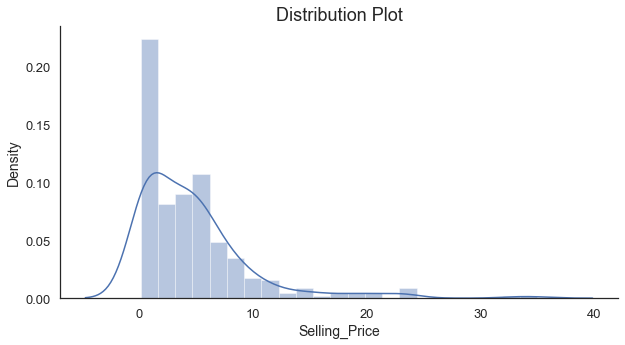

In [38]:
print(df[TARGET].skew())
dist_plots(df[TARGET])

We notice that the distributiuon is right skewed. Let's try to fix this using log transformation

Here we are defining a function that takes care of the log transform of a column.

In [39]:
def transform_target(df, target):
    """
    Apply a log transformation to the target for better optimization 
    during training.
    """
    df[target] = np.log(df[target])
    return df

df = transform_target(df, TARGET)

-0.474319246643737


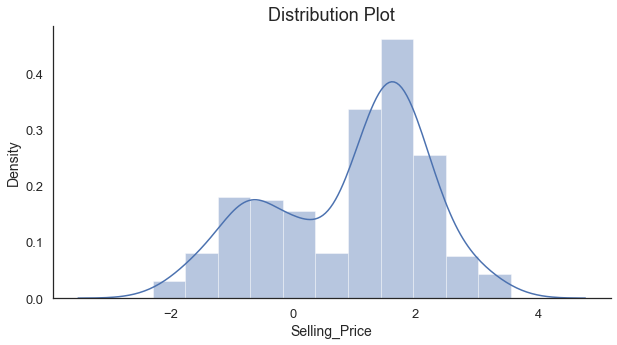

In [40]:
print(df[TARGET].skew())
dist_plots(df[TARGET])

#### Handling Categorical Data :

So that the model can understand categorical data, we must transform them in a numerical form. There is various ways to do that.

Some of them categorical data are,

Nominal Data --> data are not in any order --> OneHotEncoder is used in this case

Ordinal data --> data are in order --> LabelEncoder is used in this case

Since all our columns are of the nominal type, we are going to use one hot encoding. To do so, we are defining a function that uses get_dummies() method to one hot encode our categorical data.

In [41]:
# Convert the Categorical variables to one-hot encoded features...
# It will help in the training process
def create_one_hot(df, categ_colums):
    """
    Creates one_hot encoded fields for the specified categorical columns...
    Args
        df
        categ_colums
    Returns
        df
    """
    df = pd.get_dummies(df, columns=categ_colums)
    return df

Let's get all numerical and categorical columns. We have to call our function again since we've been prepraring the data and adding/removing/transforming columns.

In [42]:
object_cols, num_cols, feature_cols = get_all_cols(df, "Selling_Price")

df = create_one_hot(df, object_cols)

#### Feature Selection :

Finding out the best feature which will contribute and have good relation with target variable. Following are some of the feature selection methods,

1. heatmap
2. feature_importance_
3. SelectKBest

In [44]:
object_cols, num_cols, feature_cols = get_all_cols(df, "Selling_Price")

feature_cols_plus_target = [TARGET] + feature_cols

Note: We are filtering uptil the 4th column since after the 11th column, it is the one hot encoded features. I decided to not plot those since the heatmap will be too dense.

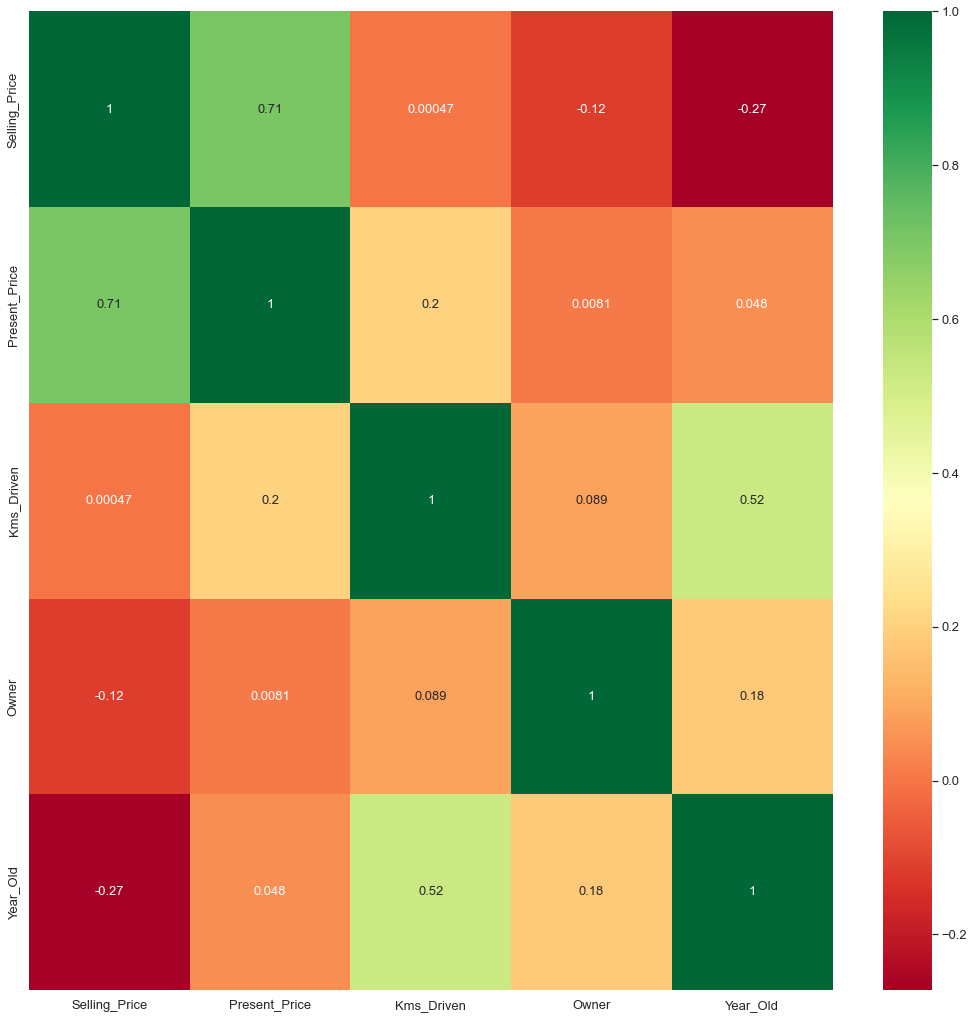

In [45]:
heatmap_df = df[feature_cols_plus_target].iloc[:,:5]

plt.figure(figsize = (18,18))
sns.heatmap(heatmap_df.corr(), annot = True, cmap = "RdYlGn")

plt.show()

##### We notice what has the highest effect on our target variable. We notice:

The Present_Price has the highest positive correlation with the target variable which makes sense. Present listed price is usually a good indication of selling price.
The Year_Old has the highest negative correlation with the target variable which also makes sense. The older the car, the more the deterioration thus the lower the price.


##### Feature importance (Extra Tree Regressor) :


You can also use the ExtraTressRegressor from sklearn which will allows you to easily see what are the important features for the Target Price.

In [46]:
object_cols, num_cols, feature_cols = get_all_cols(df, "Selling_Price")

X = df[feature_cols]
y = df[TARGET]

In [47]:
# Important feature using ExtraTreesRegressor
from sklearn.ensemble import ExtraTreesRegressor
selection = ExtraTreesRegressor()
selection.fit(X, y)

ExtraTreesRegressor()

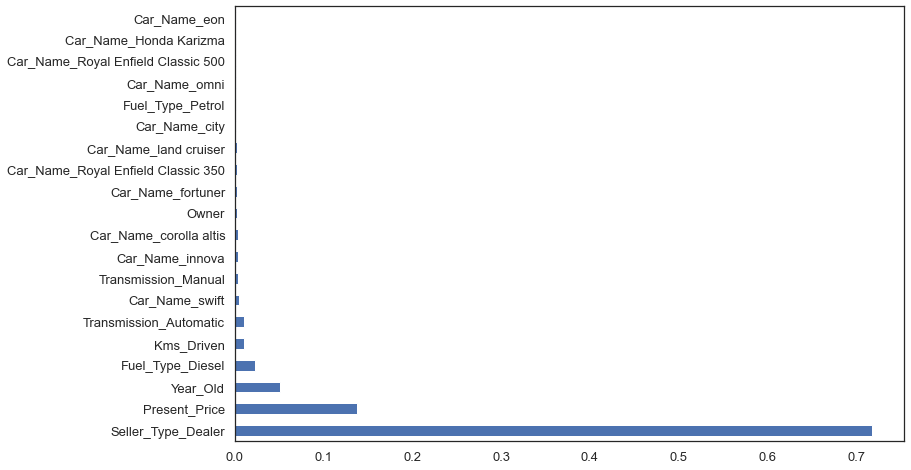

In [48]:
plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

From the feature importance plot, it is clear that the most important feature here is the Seller_Type_Dealer. (Note that we didn't plot the categorical features with the heatmap). This makes sense since whenever a dealer is selling the car, the car price is heavily inflated.

We also notice that the second most important feature is the Present Price as found witht heatmap.

##### Splitting the data :
In this section, we will split the data in train and test set. Do not confuse test set with our test data. Test set is just a subsample of train_df.

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

##### Models :
In this section, we will explore two models:

RandomForestRegressor
XGBRegressor


In [50]:
from xgboost import XGBRegressor 
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()
xgboost_model = XGBRegressor(n_jobs = -1)

hist_rf_model = rf_model.fit(X_train, y_train)
hist_xgboost_model= xgboost_model.fit(X_train, y_train)

##### Predicting :

In this subsection, we will use the basic trained model to predict on our test set (not test data).

In [51]:
y_pred_rf = rf_model.predict(X_test)
y_pred_xgboost = xgboost_model.predict(X_test)

In [52]:
print(rf_model.score(X_train, y_train))
print(xgboost_model.score(X_train, y_train))

0.9954538580136971
0.9999356433552934


In [53]:
print(rf_model.score(X_test, y_pred_rf))
print(xgboost_model.score(X_test, y_pred_xgboost))

1.0
1.0


##### Evaluating :
In this subsection, we evaluate using plots and metrics to see if our predictions are good or not.

###### Distribution plots :

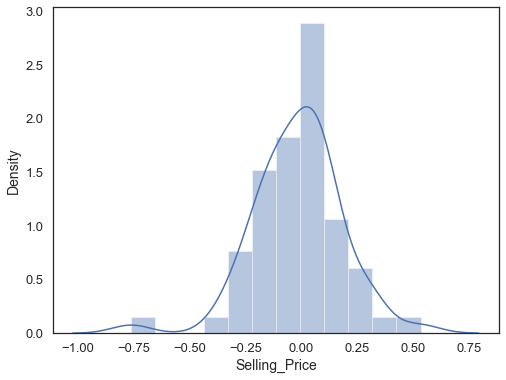

In [54]:
sns.distplot(y_test-y_pred_rf)
plt.show()

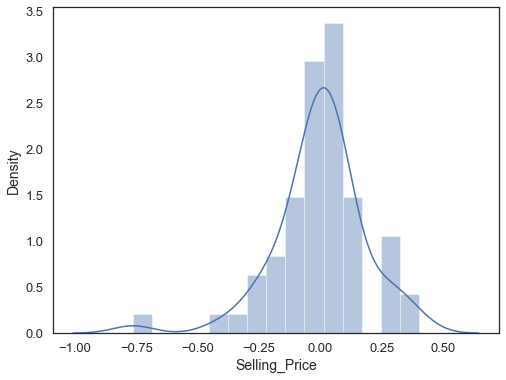

In [55]:
sns.distplot(y_test-y_pred_xgboost)
plt.show()

We notice that the disth plot for the XGBoost seems tigher and a bit less spread. As well the density at 0 is much higher for the XGBoost than the RandomForest. This means there is more predictions for the XGBoost model that is closer to the expected output.

##### Scatter plot of Target and Predicted :

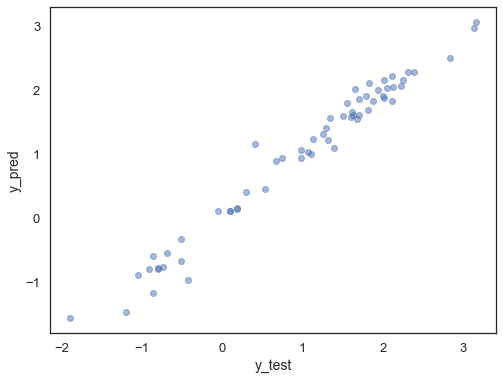

In [56]:
plt.scatter(y_test, y_pred_rf, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

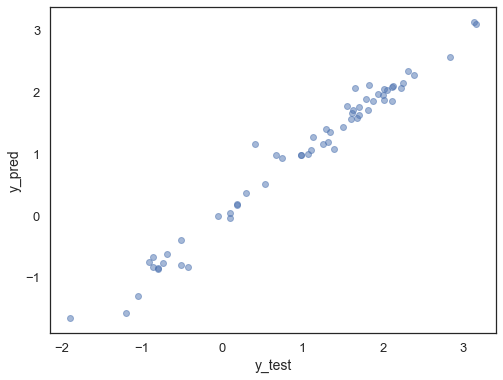

In [57]:
plt.scatter(y_test, y_pred_xgboost, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

We notice that the scatter plot for the XGBoost model is much tighter. The tighter and the more linear this graph is, the more the predicted and expected values are similar. In a perfect model, we would expect this slope to be 1.

##### Metrics to decide on which model to use :
I have chosen a handful of metrics, however the main one used of regression is usually R2 score.

In [58]:
from sklearn import metrics

print('RandomForest')
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_rf))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_rf))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)))

print('XGBoost')
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_xgboost))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_xgboost))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_xgboost)))

RandomForest
MAE: 0.14537821107439772
MSE: 0.038515086579469206
RMSE: 0.19625260910232303
XGBoost
MAE: 0.1252007607153089
MSE: 0.03371250905578623
RMSE: 0.1836096649302161


In [59]:
metrics.r2_score(y_test, y_pred_rf)

0.9730847430541509

In [60]:
metrics.r2_score(y_test, y_pred_xgboost)

0.9764408982528566

XGBoost outperformed the RandomForest on all three metrics. I decided to proceed with the XGBoost model for the hyperparameter tuning.

In [61]:
from sklearn.model_selection import RandomizedSearchCV

# Create the random grid for the XGBoost model

params = {
 "learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
 "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}



In [63]:
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
xgb_model_tuned = RandomizedSearchCV(estimator = xgboost_model, param_distributions = params, 
                                     scoring='neg_mean_squared_error', n_iter = 50, cv = 5, verbose=2, 
                                     random_state=42, n_jobs = 1)

In [64]:
xgb_model_tuned.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.3, max_depth=5, min_child_weight=5; total time=   0.0s
[CV] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.3, max_depth=5, min_child_weight=5; total time=   0.0s
[CV] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.3, max_depth=5, min_child_weight=5; total time=   0.0s
[CV] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.3, max_depth=5, min_child_weight=5; total time=   0.0s
[CV] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.3, max_depth=5, min_child_weight=5; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.3, max_depth=15, min_child_weight=3; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.3, max_depth=15, min_child_weight=3; total time=   0.0s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.3, max_depth=15, min_child_weight=3; total time=   0.0s
[CV] END colsample_bytree=0.7, 

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          callbacks=None, colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=0, gpu_id=-1,
                                          grow_policy='depthwise',
                                          importance_type=None,
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_bin=256, m...
                                          num_parallel_tree=1, predictor='auto',
                                          random_state=0, reg_alpha

We can check the best parameters by accessing the following attribute:

In [66]:
xgb_model_tuned.best_params_


{'min_child_weight': 5,
 'max_depth': 8,
 'learning_rate': 0.25,
 'gamma': 0.1,
 'colsample_bytree': 0.7}

##### Predicting with tuned model :

Let us used our tuned model to predict the Target price and see if it does better than our untuned model.

In [67]:
prediction = xgb_model_tuned.predict(X_test)

#### Evaluating tuned model :
    

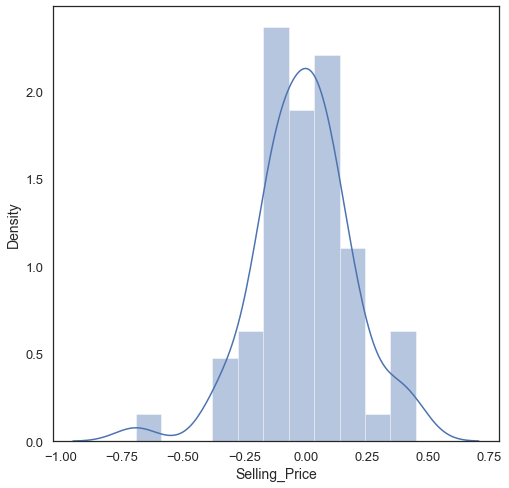

In [69]:
plt.figure(figsize = (8,8))
sns.distplot(y_test-prediction)
plt.show()

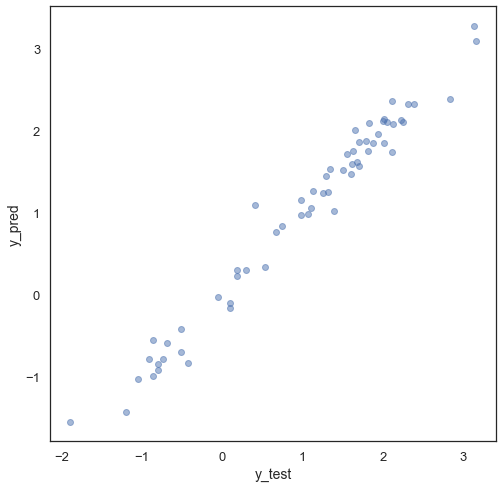

In [70]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [71]:
# XGBoost
# MAE: 0.12520076071530886
# MSE: 0.03371250905578623
# RMSE: 0.1836096649302161

print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 0.1441946040582448
MSE: 0.03737593315567135
RMSE: 0.19332856270006082


In [72]:
# XGBoost
# 0.9999356433552934

metrics.r2_score(y_test, prediction)

0.9738808105130413

We notice from the plots and metrics that the hyper parameter tuning does not have significant improvements on the performance. This is due to the fact that we do not have a large number of sample data.